In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from scripts.pre_process_dataset import PreProcess
from scripts.import_dataset import ImportDataset
from scripts.plots import PlotReport

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from scikeras.wrappers import KerasClassifier

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [12]:
data = ImportDataset()
df = data.read_dataset()
print(f"✅ Combined dataset size: {df.shape[0]} samples")

✅ Combined dataset size: 14438 samples


In [13]:
clean_df = PreProcess(df)
df = clean_df.preprocess_dataset()
df.head(1)

,condition_label,medical_abstract
0,0,tissue change around loose prosthesis canine m...


In [14]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['medical_abstract'])
y = df['condition_label']

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_test.shape[0]}")
print(f"Test set size: {X_valid.shape[0]}")

Training set size: 10106
Validation set size: 2166
Test set size: 2166


In [16]:
# Scale features
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.transform(X_test)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [17]:
#hyper parameter tuning.

def create_model(learning_rate=0.001, dropout=0.3, hidden_units=32):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(hidden_units, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(5, activation="softmax"))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = KerasClassifier(
    model=create_model,
    epochs=40,
    batch_size=16,
    verbose=0,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
)

param_dist = {
    "model__learning_rate": [0.01, 0.001, 0.0005],
    "model__dropout": [0.2, 0.3, 0.5],
    "model__hidden_units": [8, 16],
    "batch_size": [8, 16]
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,    # only 5 trials to save CPU
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_valid, y_valid, validation_split=0.2)

print("\nBest hyperparameters:")
print(search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits



Best hyperparameters:
{'model__learning_rate': 0.0005, 'model__hidden_units': 16, 'model__dropout': 0.2, 'batch_size': 16}


In [18]:
input_dim = X_train.shape[1]
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(5, activation="softmax"))
# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history_nn = model.fit(
    X_train, 
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=10, 
    batch_size=8, 
    verbose=1
)

Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.4003 - loss: 1.5571 - val_accuracy: 0.4571 - val_loss: 1.3241
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4733 - loss: 1.3758 - val_accuracy: 0.4691 - val_loss: 1.3107
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5143 - loss: 1.2844 - val_accuracy: 0.4912 - val_loss: 1.2758
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5463 - loss: 1.2129 - val_accuracy: 0.5078 - val_loss: 1.2742
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5671 - loss: 1.1600 - val_accuracy: 0.4917 - val_loss: 1.2926
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5787 - loss: 1.1333 - val_accuracy: 0.4917 - val_loss: 1.3213
Epoch 7/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5914 - loss: 1.1253 - val_accuracy: 0.4866 - val_loss: 1.3295
Epoch 8/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5932 - los

In [19]:
loss, acc = model.evaluate(X_test, y_test)
print("Accuracy:", acc)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4898 - loss: 1.3844
Accuracy: 0.4898430407047272


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.65      0.50       753
           1       0.67      0.57      0.62       453
           2       0.32      0.07      0.12       209
           3       0.47      0.19      0.27       269
           4       0.62      0.51      0.56       482

    accuracy                           0.49      2166
   macro avg       0.49      0.40      0.41      2166
weighted avg       0.51      0.49      0.47      2166



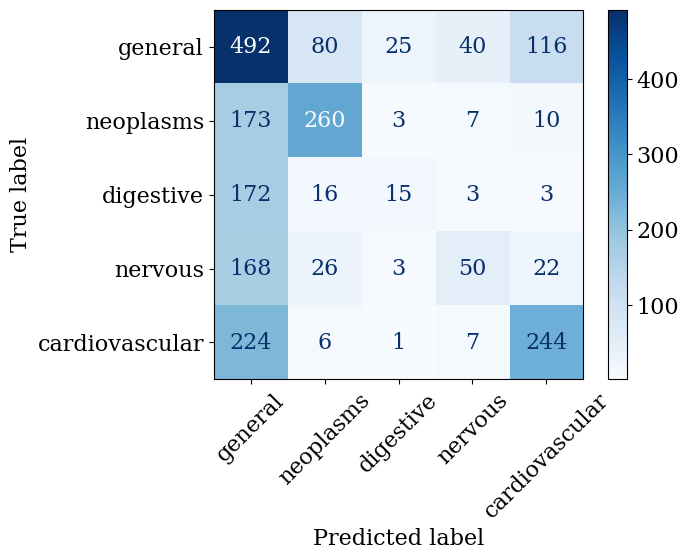

In [20]:
plot = PlotReport(model, X_test, y_test)
plot.get_confusion_matrix(True, True)
plot.print_confusion_matrix("Confusion_NN.pdf")

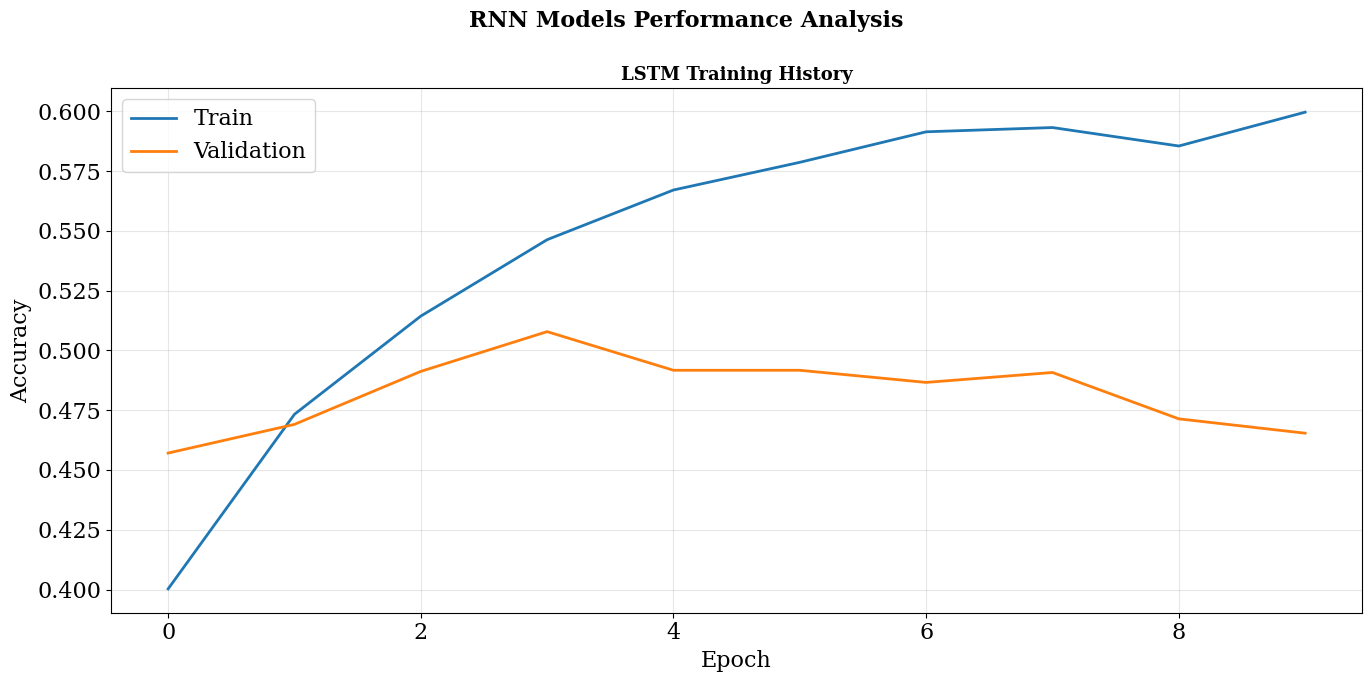

In [21]:
# Graph 1: Model Comparison
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(history_nn.history['accuracy'], label='Train', linewidth=2)
ax.plot(history_nn.history['val_accuracy'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('LSTM Training History', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)


plt.suptitle('RNN Models Performance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()